In [290]:
import pandas as pd
import numpy as np

# model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# for calculating the accuracy
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# for splitting the data
from sklearn.model_selection import train_test_split

# graphs
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data

In [141]:
# cars data from kaggle
# https://www.kaggle.com/datasets/CooperUnion/cardataset
cars_df = pd.read_csv("../../Datasets/cars/data.csv")

In [142]:
cars_df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### Normalization

In [143]:
# convert to lowercase and replace whitespaces(' ') with an underscore(_)
cars_df.columns = cars_df.columns.str.lower().str.replace(' ', '_')

### Exploratory Data Analysis

In [144]:
len(cars_df)

11914

In [145]:
cars_df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

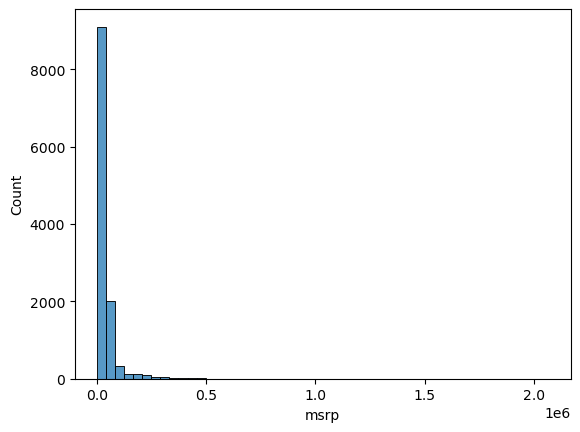

In [146]:
# histogram
sns.histplot(cars_df.msrp, bins=50)
plt.show()

This is a bad distribution for the model because of the long tail.

In [147]:
# fix tail with log transformation
log_transformed_prices = np.log1p(cars_df.msrp)

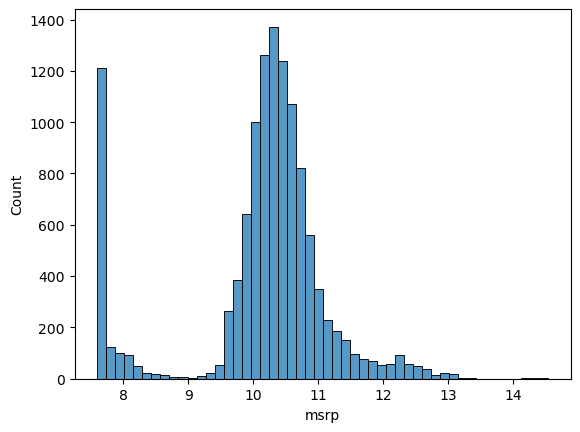

In [148]:
sns.histplot(log_transformed_prices, bins=50)
plt.show()

This is acceptable. A normal distribution with a weird sample around ***< 7.5ish msrp***

### Dataset Splitting

In [149]:
# extract target value
y = cars_df.msrp

In [150]:
### 60% training, 20% validation, 20% testing

# split the data into 60% training and 40% temporary (validation + testing)
train_X, tmp_X, train_y, tmp_y = train_test_split(cars_df, y, test_size=0.4, random_state=1)

# further split the temporary data into 20% validation and 20% testing
val_X, test_X, val_y, test_y = train_test_split(tmp_X, tmp_y, test_size=0.5, random_state=1)

In [151]:
del train_X['msrp']
del val_X['msrp']
del test_X['msrp']

In [152]:
train_X.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
3840,Hyundai,Elantra GT,2016,regular unleaded,173.0,4.0,MANUAL,front wheel drive,4.0,"Hatchback,Performance",Compact,4dr Hatchback,33,24,1439
5780,Mitsubishi,i-MiEV,2017,electric,66.0,NaN,DIRECT_DRIVE,rear wheel drive,4.0,Hatchback,Compact,4dr Hatchback,102,121,436
8637,Audi,RS 5,2014,premium unleaded (required),450.0,8.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Midsize,Convertible,22,16,3105
5620,Volkswagen,GTI,2012,premium unleaded (recommended),200.0,4.0,AUTOMATED_MANUAL,front wheel drive,2.0,"Hatchback,Performance",Compact,2dr Hatchback,33,24,873
122,Mazda,2,2014,regular unleaded,100.0,4.0,MANUAL,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,35,29,586


In [153]:
train_y.head()

3840    18800
5780    22995
8637    77900
5620    27375
122     16210
Name: msrp, dtype: int64

In [154]:
# extract as numpy array and log transform target value
train_y = np.log1p(train_y.values)
val_y = np.log1p(val_y.values)
test_y = np.log1p(test_y.values)

### Features

In [155]:
cars_df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

Extract categorical variables. They are usually *objects*.

In [156]:
categorical_variables = [
    'make', 'model', 'engine_fuel_type', 'transmission_type',
    'driven_wheels', 'vehicle_size', 'vehicle_style', 'number_of_doors',
    'market_category'
]

In [157]:
list(cars_df['make'].value_counts().head(10).index)

['Chevrolet',
 'Ford',
 'Volkswagen',
 'Toyota',
 'Dodge',
 'Nissan',
 'GMC',
 'Honda',
 'Mazda',
 'Cadillac']

In [158]:
category = {}

for v in categorical_variables:
    category[v] = list(cars_df[v].value_counts().head(10).index)

In [159]:
category

{'make': ['Chevrolet',
  'Ford',
  'Volkswagen',
  'Toyota',
  'Dodge',
  'Nissan',
  'GMC',
  'Honda',
  'Mazda',
  'Cadillac'],
 'model': ['Silverado 1500',
  'Tundra',
  'F-150',
  'Sierra 1500',
  'Beetle Convertible',
  'Tacoma',
  'GTI',
  'Frontier',
  'Accord',
  'Beetle'],
 'engine_fuel_type': ['regular unleaded',
  'premium unleaded (required)',
  'premium unleaded (recommended)',
  'flex-fuel (unleaded/E85)',
  'diesel',
  'electric',
  'flex-fuel (premium unleaded required/E85)',
  'flex-fuel (premium unleaded recommended/E85)',
  'flex-fuel (unleaded/natural gas)',
  'natural gas'],
 'transmission_type': ['AUTOMATIC',
  'MANUAL',
  'AUTOMATED_MANUAL',
  'DIRECT_DRIVE',
  'UNKNOWN'],
 'driven_wheels': ['front wheel drive',
  'rear wheel drive',
  'all wheel drive',
  'four wheel drive'],
 'vehicle_size': ['Compact', 'Midsize', 'Large'],
 'vehicle_style': ['Sedan',
  '4dr SUV',
  'Coupe',
  'Convertible',
  '4dr Hatchback',
  'Crew Cab Pickup',
  'Extended Cab Pickup',
  'Wa

In [397]:
def prepare_X(df):
    # work with a copy of the dataframe to avoid manipulating
    # the actual dataframe
    df = df.copy()

    # base features (numerical)
    features = [
        'year', 'engine_hp', 'engine_cylinders', 
        'highway_mpg', 'city_mpg', 'popularity'
    ]

    # convert year made to car age
    df['year'] = max(df['year']) - df['year']

    for c, values in category.items():
        for v in values:
            # 0/1 columns
            df[('%s_%s' % (c, v)).lower()] = (df[c] == v).astype('int')
            features.append(('%s_%s' % (c, v)).lower())
    
    # fill NaN with zeros
    X = df[features].fillna(0)
    # return as numpy array
    return X.values

# Model

In [398]:
def rmse(prediction, target):
    return np.sqrt((np.square(prediction - target).mean()).sum())

### Training

In [399]:
# create a random forest regressor model with sklearn
rf_model = RandomForestRegressor(random_state=1)

# fit model
rf_model.fit(prepare_X(train_X), train_y)

RandomForestRegressor(random_state=1)

### Validation

In [400]:
val_predictions = rf_model.predict(prepare_X(val_X))
rmse(val_predictions, val_y)

0.10887180419483726

In [401]:
print("Mean absolute error: ", mean_absolute_error(np.expm1(val_predictions), np.expm1(val_y)))

Mean absolute error:  3638.510026733139


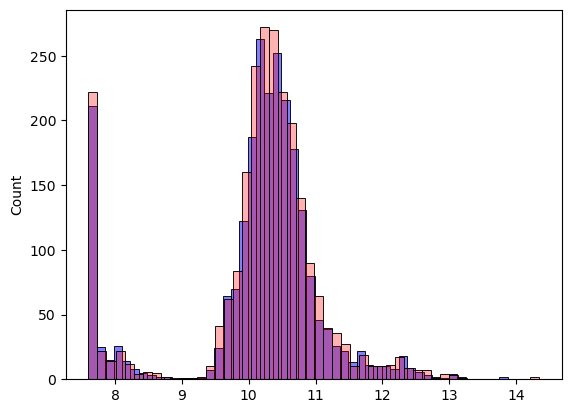

In [402]:
sns.histplot(val_predictions, bins=50, color='blue', alpha=0.5)
sns.histplot(val_y, bins=50, color='red', alpha=0.3)
plt.show()

### Testing

In [403]:
# concatenate features
full_X = pd.concat([train_X, val_X])
# concatenate target
full_y = np.concatenate([train_y, val_y])

In [404]:
# confirm length
len(full_X), len(full_y)

(9531, 9531)

In [405]:
rf_model.fit(prepare_X(full_X), full_y)

RandomForestRegressor(random_state=1)

In [406]:
test_predictions = rf_model.predict(prepare_X(test_X))
rmse(test_predictions, test_y)

0.10559060120770968

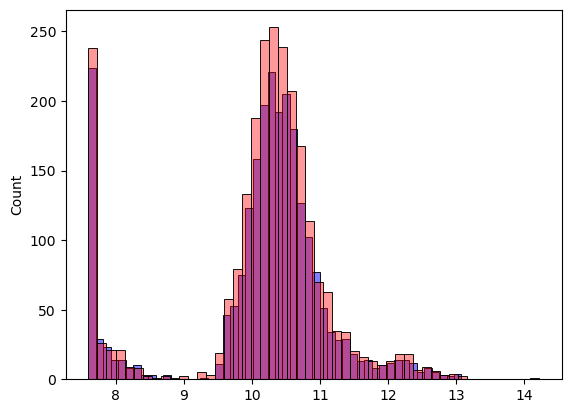

In [407]:
sns.histplot(test_predictions, bins=50, color='blue', alpha=0.5)
sns.histplot(test_y, bins=50, color='red', alpha=0.4)
plt.show()

#### Sample car price prediction

In [408]:
car = cars_df.iloc[540].to_dict()

In [409]:
sample_df = pd.DataFrame([car])
del sample_df['msrp']

In [410]:
sample_df

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
0,FIAT,500e,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Hatchback,Compact,2dr Hatchback,103,121,819


In [411]:
prepare_X(sample_df)

array([[  0.,   0.,   0., 103., 121., 819.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.]])

In [412]:
price_prediction = rf_model.predict(prepare_X(sample_df))

In [413]:
print("Prediction: ", np.expm1(price_prediction[0]))
print("Actual Price: ", car['msrp'])

Prediction:  31716.63565810505
Actual Price:  31800


# Observations

- The model is very bad at predicting the price when the actual price is small(e.g. msrp<=10000).
- It can be very reliable when the price range is at mid-level(20k-50k or even above)
  